Segmentation shape: (4096, 850)
Cropped Segmentation shape: (1250, 850)
Vertical profile shape: (1250,)
mask_255 shape: (1250, 850)
Detected 255 segments (row ranges):
Segment 1: rows 8 → 8
Segment 2: rows 105 → 164
Segment 3: rows 183 → 250
Segment 4: rows 599 → 638
Segment 5: rows 755 → 857
Segment 6: rows 868 → 1030
Segment 7: rows 1056 → 1142


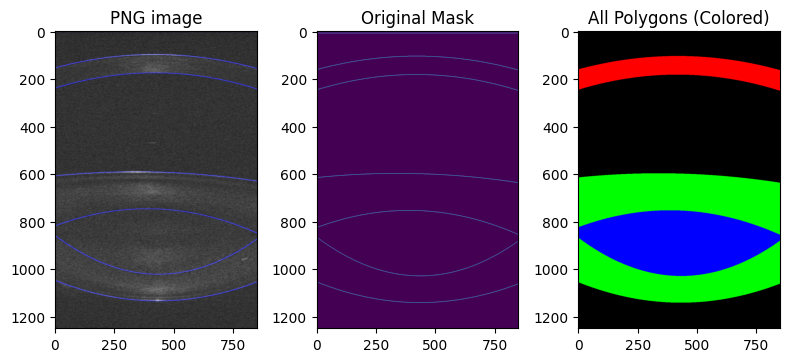

In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

png_img = cv2.imread("data2/Horizontal/Image.png", cv2.IMREAD_UNCHANGED)
png_img= png_img[:1250, :850]  # crop to match segmentation size

segmentation = np.fromfile("data2/Horizontal/Segmentation.bin", dtype=np.uint8)
segmentation= segmentation[:4096*850].reshape(850, 4096).T  # crop and transpose to (1250, 850)
print("Segmentation shape:", segmentation.shape)
segmentation = segmentation[:1250, :850]  # crop to (1250, 850)
print("Cropped Segmentation shape:", segmentation.shape)

mask_255 = (segmentation == 255).astype(np.uint8)
vertical_profile = mask_255.sum(axis=1)  # shape: (4096,)
print("Vertical profile shape:", vertical_profile.shape)
print("mask_255 shape:", mask_255.shape)

# Find rows where 255 exists
rows_with_255 = np.where(vertical_profile > 0)[0]

# Detect continuous segments
segments = []
start = rows_with_255[0]
for i in range(1, len(rows_with_255)):
    if rows_with_255[i] != rows_with_255[i-1] + 1:
        end = rows_with_255[i-1]
        segments.append((start, end))
        start = rows_with_255[i]
segments.append((start, rows_with_255[-1]))

print("Detected 255 segments (row ranges):")
for i, (s,e) in enumerate(segments):
    print(f"Segment {i+1}: rows {s} → {e}")

seg = segmentation.copy()

# Define regions of interest from segments
regions = {
    "Cornea":   (segments[1][0], segments[2][1]),
    "Lens":     (segments[3][0], segments[6][1]),
    "Nucleus":  (segments[4][0], segments[5][1]),
    # "Retina":   (segments[7][0]-1, segments[7][1]+1),
}

h = seg.shape[1]  # number of columns
polygons = {}     # store polygons

for name, (row_start, row_end) in regions.items():
    top_curve = []
    bottom_curve = []

    for col in range(h):
        col_segment = seg[row_start:row_end+1, col]
        rows = np.where(col_segment == 255)[0]

        if len(rows) >= 1:  # must have both top and bottom
            top_curve.append((col, row_start + rows[0]))
            bottom_curve.append((col, row_start + rows[-1]))

    # Combine into polygon
    polygon = np.array(top_curve + bottom_curve[::-1], dtype=np.int32)
    polygons[name] = polygon

# --- Create one combined colored mask ---
colored_mask = np.zeros((*mask_255.shape, 3), dtype=np.uint8)

# Assign unique colors (BGR format for cv2)
colors = {
    "Cornea":  (255, 0, 0),     # Blue
    "Lens":    (0, 255, 0),     # Green
    "Nucleus": (0, 0, 255),     # Red
    "Retina":  (255, 255, 0),   # Cyan
}

for name, polygon in polygons.items():
    if polygon.shape[0] > 0:
        cv2.fillPoly(colored_mask, [polygon], colors[name])
    else:
        print(f"Warning: Polygon for {name} is empty, skipping fillPoly.")

# --- Plot results ---
plt.figure(figsize=(8, 10))

plt.subplot(1, 3, 1)
plt.title("PNG image")
plt.imshow(png_img)

plt.subplot(1, 3, 2)
plt.title("Original Mask")
plt.imshow(seg)

plt.subplot(1, 3, 3)
plt.title("All Polygons (Colored)")
plt.imshow(colored_mask)

plt.tight_layout()
plt.show()


Detected 255 segments (row ranges):
Segment 1: rows 8 → 8
Segment 2: rows 105 → 164
Segment 3: rows 183 → 250
Segment 4: rows 599 → 638
Segment 5: rows 755 → 857
Segment 6: rows 868 → 1030
Segment 7: rows 1056 → 1142
Segment 8: rows 3457 → 3457


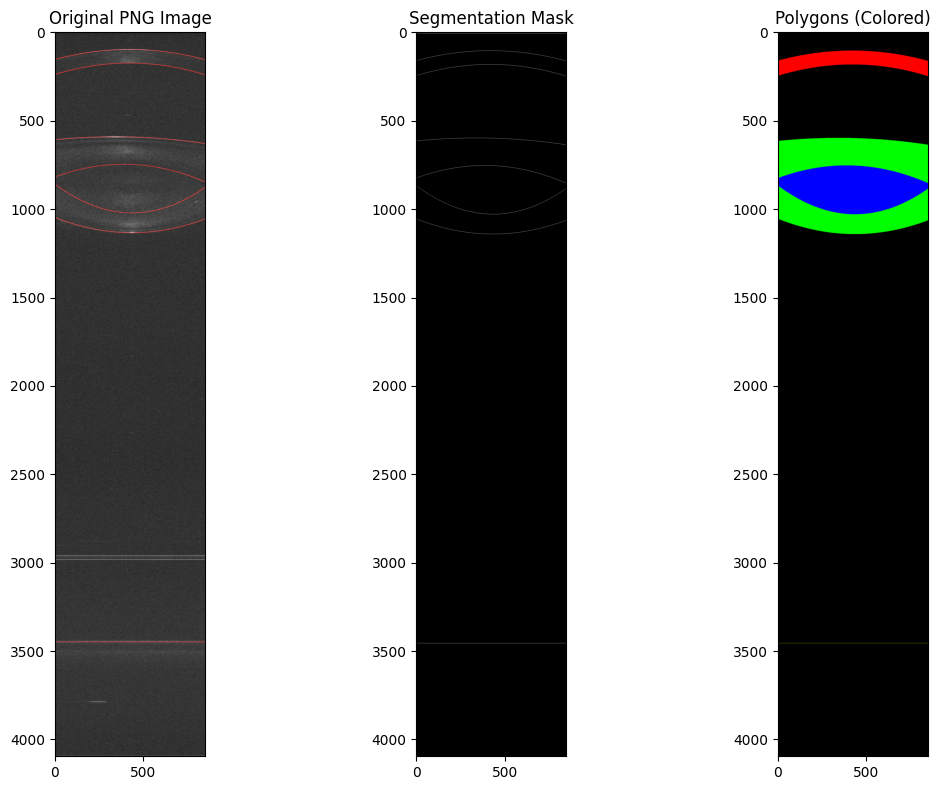

In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Load data ---
png_img = cv2.imread("data2/Horizontal/Image.png", cv2.IMREAD_UNCHANGED)
segmentation = np.fromfile("data2/Horizontal/Segmentation.bin", dtype=np.uint8)

# Reshape segmentation (use only valid part)
segmentation = segmentation[:4096*850].reshape(850, 4096).T
mask_255 = (segmentation == 255).astype(np.uint8)

# --- Detect continuous row segments ---
vertical_profile = mask_255.sum(axis=1)
rows_with_255 = np.where(vertical_profile > 0)[0]

segments = []
start = rows_with_255[0]
for i in range(1, len(rows_with_255)):
    if rows_with_255[i] != rows_with_255[i-1] + 1:
        segments.append((start, rows_with_255[i-1]))
        start = rows_with_255[i]
segments.append((start, rows_with_255[-1]))

print("Detected 255 segments (row ranges):")
for i, (s, e) in enumerate(segments):
    print(f"Segment {i+1}: rows {s} → {e}")

# --- Define anatomical regions from segments ---
regions = {
    "Cornea":  (segments[1][0], segments[2][1]),
    "Lens":    (segments[3][0], segments[6][1]),
    "Nucleus": (segments[4][0], segments[5][1]),
    "Retina":  (segments[7][0]-1, segments[7][1]+1),  # small padding
}

# --- Build polygons for each region ---
def build_polygon(seg, row_start, row_end):
    """Extract polygon by tracing top and bottom 255 values column-wise."""
    h = seg.shape[1]
    top_curve, bottom_curve = [], []

    for col in range(h):
        col_segment = seg[row_start:row_end+1, col]
        rows = np.where(col_segment == 255)[0]
        if len(rows) >= 1:
            top_curve.append((col, row_start + rows[0]))
            bottom_curve.append((col, row_start + rows[-1]))

    if not top_curve or not bottom_curve:
        return np.array([], dtype=np.int32)

    return np.array(top_curve + bottom_curve[::-1], dtype=np.int32)

polygons = {name: build_polygon(segmentation, *bounds) for name, bounds in regions.items()}

# --- Create one combined colored mask ---
colored_mask = np.zeros((*mask_255.shape, 3), dtype=np.uint8)

colors = {
    "Cornea":  (255, 0, 0),     # Blue
    "Lens":    (0, 255, 0),     # Green
    "Nucleus": (0, 0, 255),     # Red
    "Retina":  (255, 255, 0),   # Cyan
}

for name, polygon in polygons.items():
    if polygon.shape[0] > 0:
        cv2.fillPoly(colored_mask, [polygon], colors[name])
    else:
        print(f"Warning: Polygon for {name} is empty, skipping fillPoly.")

# --- Plot results ---
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.title("Original PNG Image")
plt.imshow(cv2.cvtColor(png_img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Segmentation Mask")
plt.imshow(segmentation, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Polygons (Colored)")
plt.imshow(colored_mask)

plt.tight_layout()
plt.show()


Detected 255 segments (row ranges):
Segment 1: rows 8 → 8
Segment 2: rows 105 → 164
Segment 3: rows 183 → 250
Segment 4: rows 599 → 638
Segment 5: rows 755 → 857
Segment 6: rows 868 → 1030
Segment 7: rows 1056 → 1142


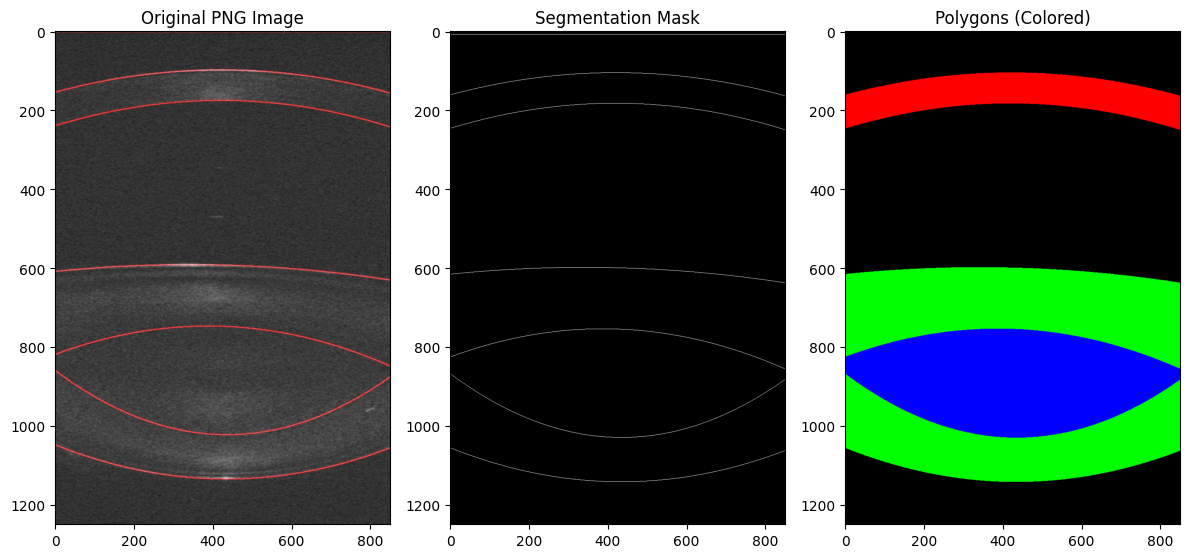

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Load data ---
png_img = cv2.imread("data2/Horizontal/Image.png", cv2.IMREAD_UNCHANGED)
png_img = png_img[:1250, :850]  # crop to match segmentation size

segmentation = np.fromfile("data2/Horizontal/Segmentation.bin", dtype=np.uint8)

# Reshape segmentation (use only valid part)
segmentation = segmentation[:4096*850].reshape(850, 4096).T
segmentation = segmentation[:1250, :850]  # crop to (1250, 850)
mask_255 = (segmentation == 255).astype(np.uint8)

# --- Detect continuous row segments ---
vertical_profile = mask_255.sum(axis=1)
rows_with_255 = np.where(vertical_profile > 0)[0]

segments = []
start = rows_with_255[0]
for i in range(1, len(rows_with_255)):
    if rows_with_255[i] != rows_with_255[i-1] + 1:
        segments.append((start, rows_with_255[i-1]))
        start = rows_with_255[i]
segments.append((start, rows_with_255[-1]))

print("Detected 255 segments (row ranges):")
for i, (s, e) in enumerate(segments):
    print(f"Segment {i+1}: rows {s} → {e}")

# --- Define anatomical regions from segments ---
regions = {
    "Cornea":  (segments[1][0], segments[2][1]),
    "Lens":    (segments[3][0], segments[6][1]),
    "Nucleus": (segments[4][0], segments[5][1]),
    # "Retina":  (segments[7][0]-1, segments[7][1]+1),  # small padding
}

# --- Build polygons for each region ---
def build_polygon(seg, row_start, row_end):
    """Extract polygon by tracing top and bottom 255 values column-wise."""
    h = seg.shape[1]
    top_curve, bottom_curve = [], []

    for col in range(h):
        col_segment = seg[row_start:row_end+1, col]
        rows = np.where(col_segment == 255)[0]
        if len(rows) >= 2:
            top_curve.append((col, row_start + rows[0]))
            bottom_curve.append((col, row_start + rows[-1]))

    if not top_curve or not bottom_curve:
        return np.array([], dtype=np.int32)

    return np.array(top_curve + bottom_curve[::-1], dtype=np.int32)

polygons = {name: build_polygon(segmentation, *bounds) for name, bounds in regions.items()}

# --- Create one combined colored mask ---
colored_mask = np.zeros((*mask_255.shape, 3), dtype=np.uint8)

colors = {
    "Cornea":  (255, 0, 0),     # Blue
    "Lens":    (0, 255, 0),     # Green
    "Nucleus": (0, 0, 255),     # Red
    "Retina":  (255, 255, 0),   # Cyan
}

for name, polygon in polygons.items():
    if polygon.shape[0] > 0:
        cv2.fillPoly(colored_mask, [polygon], colors[name])
    else:
        print(f"Warning: Polygon for {name} is empty, skipping fillPoly.")

# --- Plot results ---
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.title("Original PNG Image")
plt.imshow(cv2.cvtColor(png_img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 2)
plt.title("Segmentation Mask")
plt.imshow(segmentation, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Polygons (Colored)")
plt.imshow(colored_mask)

plt.tight_layout()
plt.show()


In [ ]:
# Merge all polygons into one mask
label_mask = np.zeros_like(mask_255, dtype=np.uint8)
label_mask = np.ascontiguousarray(label_mask)  # Ensure contiguous memory
class_ids = {"Cornea": 1, "Lens": 2, "Nucleus": 3, "Retina": 4}

for name, polygon in polygons.items():
    cv2.fillPoly(label_mask, [polygon], class_ids[name])

# Save mask and original image
np.save("mask_labels.npy", label_mask)   # for training
cv2.imwrite("mask_labels.png", label_mask)  # visualization/debug
# print(label_mask)
# plt.plot(label_mask)
print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)
# np.set_printoptions(threshold=np.prod(label_mask.shape))
print(label_mask)

In [6]:
def resize_with_padding(img, target_size=(512, 512)):
    h, w = img.shape[:2]
    th, tw = target_size

    # Scale while keeping aspect ratio
    scale = min(tw / w, th / h)
    new_w, new_h = int(w * scale), int(h * scale)

    # Resize
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # Pad to target size
    pad_w = (tw - new_w) // 2
    pad_h = (th - new_h) // 2
    padded = cv2.copyMakeBorder(resized, pad_h, th-new_h-pad_h,
                                pad_w, tw-new_w-pad_w,
                                cv2.BORDER_CONSTANT, value=0)
    return padded

In [8]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm

print("current working dir:", os.getcwd())

resize = True
# --- Paths ---
data_root = "./data2"  # root dataset folder
save_images = "./data2/dataset/images"
save_labels = "./data2/dataset/labels"
save_visual = "./data2/dataset/visual"
os.makedirs(save_images, exist_ok=True)
os.makedirs(save_labels, exist_ok=True)
os.makedirs(save_visual, exist_ok=True)

# --- Color mapping to class IDs for label masks ---
class_ids = {
    "Cornea": 1,
    "Lens": 2,
    "Nucleus": 3,
    # "Retina": 4,
}
colors = {
    "Cornea":  (255, 0, 0),     # Blue
    "Lens":    (0, 255, 0),     # Green
    "Nucleus": (0, 0, 255),     # Red
    "Retina":  (255, 255, 0),   # Cyan
}

# --- Polygon building function ---
def build_polygon(seg, row_start, row_end):
    h = seg.shape[1]
    top_curve, bottom_curve = [], []
    for col in range(h):
        col_segment = seg[row_start:row_end+1, col]
        rows = np.where(col_segment == 255)[0]
        if len(rows) >= 2: # must have both top and bottom
            top_curve.append((col, row_start + rows[0]))
            bottom_curve.append((col, row_start + rows[-1]))
    if not top_curve or not bottom_curve:
        return np.array([], dtype=np.int32)
    return np.array(top_curve + bottom_curve[::-1], dtype=np.int32)

# --- Traverse dataset ---
subfolders = ["0-6D", "6-0D"]

for group in subfolders:
    group_path = os.path.join(data_root + '/Smash/CN010_DK_28_M/OD_1.5_0_6_0', group)
    frames = sorted(os.listdir(group_path))
    
    for frame in tqdm(frames, desc=f"Processing {group}"):
        frame_path = os.path.join(group_path, frame)
        orientations = ["Horizontal", "Vertical"]
        
        for ori in orientations:
            img_path = os.path.join(frame_path, ori, "Image.png")
            seg_path = os.path.join(frame_path, ori, "Segmentation.bin")
            
            if not (os.path.exists(img_path) and os.path.exists(seg_path)):
                print(f"Skipping missing files: {img_path}")
                continue
            
            # --- Load image and segmentation ---
            png_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            seg = np.fromfile(seg_path, dtype=np.uint8)
            seg = seg[:4096*850].reshape(850, 4096).T # reshape to (4096, 850)
            
            # Crop the image and segmentation to (1250, 850)
            png_img = png_img[:1250, :850]
            seg = seg[:1250, :850]
            mask_255 = (seg == 255).astype(np.uint8)
            
            # --- Detect continuous 255 segments ---
            vertical_profile = mask_255.sum(axis=1)
            rows_with_255 = np.where(vertical_profile > 0)[0]
            segments = []
            start = rows_with_255[0]
            for i in range(1, len(rows_with_255)):
                if rows_with_255[i] != rows_with_255[i-1] + 1:
                    segments.append((start, rows_with_255[i-1]))
                    start = rows_with_255[i]
            segments.append((start, rows_with_255[-1]))
            
            # --- Define regions ---
            regions = {
                "Cornea":  (segments[1][0], segments[2][1]),
                "Lens":    (segments[3][0], segments[6][1]),
                "Nucleus": (segments[4][0], segments[5][1]),
                # "Retina":  (segments[7][0]-1, segments[7][1]+1),
            }
            
            # --- Build label mask ---
            label_mask = np.zeros(seg.shape, dtype=np.uint8)
            color_mask = np.zeros((*seg.shape, 3), dtype=np.uint8)
            for name, bounds in regions.items():
                polygon = build_polygon(seg, *bounds)
                if polygon.shape[0] > 0:
                    cv2.fillPoly(label_mask, [polygon], class_ids[name])
                    cv2.fillPoly(color_mask, [polygon], colors[name])
            
            # --- Save images and labels with unique name ---
            frame_number = frame.replace("D", "d")  # optional standardization
            filename = f"{group}_{frame_number}_{ori.lower()}"
            if resize:
                png_img = resize_with_padding(png_img, target_size=(512, 512))
                label_mask = resize_with_padding(label_mask, target_size=(512, 512))
                color_mask = resize_with_padding(color_mask, target_size=(512, 512))

            cv2.imwrite(os.path.join(save_images, f"{filename}_image.png"), png_img)
            cv2.imwrite(os.path.join(save_labels, f"{filename}_label.png"), label_mask)
            np.save(os.path.join(save_labels, f"{filename}_label.npy"), label_mask)
            cv2.imwrite(os.path.join(save_visual, f"{filename}_visual.png"), color_mask)


current working dir: /media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments


Processing 6-0D: 100%|██████████| 4/4 [00:00<00:00, 18.73it/s]


Original label_mask shape: (1250, 850)


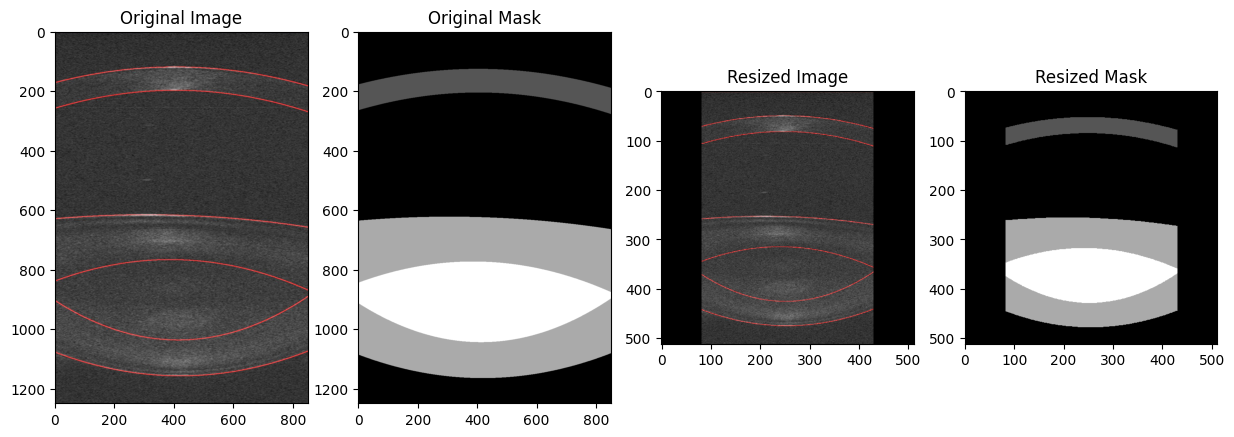

In [ ]:
import cv2
import numpy as np

def resize_with_padding(img, target_size=(512, 512)):
    h, w = img.shape[:2]
    th, tw = target_size

    # Scale while keeping aspect ratio
    scale = min(tw / w, th / h)
    new_w, new_h = int(w * scale), int(h * scale)

    # Resize
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # Pad to target size
    pad_w = (tw - new_w) // 2
    pad_h = (th - new_h) // 2
    padded = cv2.copyMakeBorder(resized, pad_h, th-new_h-pad_h,
                                pad_w, tw-new_w-pad_w,
                                cv2.BORDER_CONSTANT, value=0)
    return padded
# Example usage:
label_mask = cv2.imread("data2/dataset/labels/0-6D_0d_horizontal_label.png", cv2.IMREAD_UNCHANGED)
image = cv2.imread("data2/dataset/images/0-6D_0d_horizontal_image.png", cv2.IMREAD_UNCHANGED)
print("Original label_mask shape:", label_mask.shape)

resized_image = resize_with_padding(image, target_size=(512, 512))
resized_mask = resize_with_padding(label_mask, target_size=(512, 512))

plt.subplots(1, 4, figsize=(15, 6))

plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 4, 2)   
plt.title("Original Mask")
plt.imshow(label_mask, cmap="gray")

plt.subplot(1, 4, 3)
plt.title("Resized Image")
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 4, 4)
plt.title("Resized Mask")
plt.imshow(resized_mask, cmap="gray")



In [ ]:
import os
import shutil
import random

# Paths
root = '/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes/'  # Replace with your root path
images_dir = os.path.join('/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes/imgsFine/leftImg8bit/default/')   #(root, 'images_all')  # All images in one folder
labels_dir = os.path.join('/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes/gtFine/default')   #(root, 'labels_all')  # All GTs in one folder

print("Images source:", images_dir)
print("Labels source:", labels_dir)
import os
import shutil
import random
from glob import glob

# Output structure
for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    os.makedirs(os.path.join(root, sub), exist_ok=True)

# Collect all images
image_files = glob(os.path.join(images_dir, "*.png"))

# Shuffle for random split
random.seed(42)
random.shuffle(image_files)

# Train/val split (80/20)
split_idx = int(0.8 * len(image_files))
train_images = image_files[:split_idx]
val_images = image_files[split_idx:]

def copy_pairs(image_list, split):
    for img_path in image_list:
        img_name = os.path.basename(img_path)

        # Derive label name from image name
        # Example: CN038_..._Vertical_leftImg8bit.png
        # Label:  CN038_..._Vertical_gtFine_labelIds.png
        base_name = img_name.replace("leftImg8bit", "gtFine_labelIds")
        label_path = os.path.join(labels_dir, base_name)
        
        image_name2 = img_name.replace("leftImg8bit", "image")
        label_name2 = base_name.replace("gtFine_labelIds", "label")
        if not os.path.exists(label_path):
            print(f"[WARN] Label not found for {img_name}")
            continue

        # Copy image and label
        # shutil.copy(img_path, os.path.join(root, f"images/{split}", img_name))
        # shutil.copy(label_path, os.path.join(root, f"labels/{split}", base_name))

        shutil.copy(img_path, os.path.join(root, f"images/{split}", image_name2))
        shutil.copy(label_path, os.path.join(root, f"labels/{split}", label_name2))

# Copy train/val sets
copy_pairs(train_images, "train")
copy_pairs(val_images, "val")

print(f"✅ Done! Train: {len(train_images)} | Val: {len(val_images)}")



Images source: /media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes/imgsFine/leftImg8bit/default/
Labels source: /media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes/gtFine/default
✅ Done! Train: 79 | Val: 20


In [15]:
import os
import random
import numpy as np
import cv2
from glob import glob

# Path to your label folder (after split, e.g. train/val)
label_dir = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes/labels/train"  # change if needed

# Get all labelIds files
label_files = glob(os.path.join(label_dir, "*_gtFine_labelIds.png"))

# Pick one random file
label_file = random.choice(label_files)
print(f"Checking: {label_file}")

# Load label image (as grayscale)
label_img = cv2.imread(label_file, cv2.IMREAD_UNCHANGED)

# Print unique values
unique_classes = np.unique(label_img)
print(f"Unique class IDs in this label: {unique_classes}")

# Show basic stats
print(f"Shape: {label_img.shape}, dtype: {label_img.dtype}")


Checking: /media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes/labels/train/CN040_HT_28_F__OD__6-0D__0__Vertical_gtFine_labelIds.png
Unique class IDs in this label: [0 1 2 3]
Shape: (1600, 1600), dtype: uint8


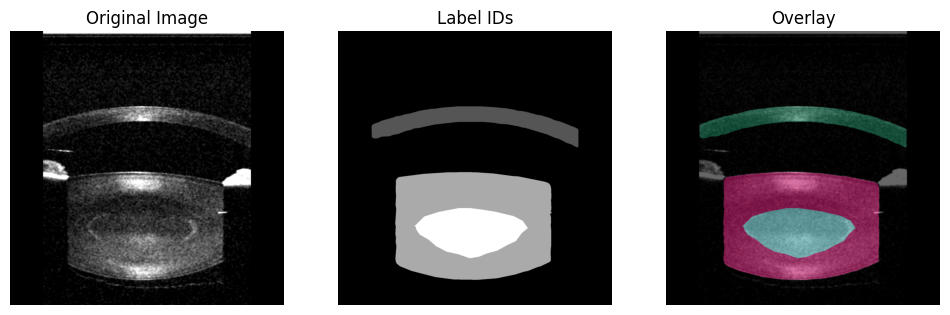

Class mapping (ID → color):
  0: (0, 0, 0)
  1: (14, 106, 71)
  2: (188, 20, 102)
  3: (121, 210, 214)


In [17]:
def visualize_image_with_labels(image_path, label_path, class_colors=None, alpha=0.5):
    """
    Visualize image with colored segmentation mask overlay.
    Args:
        image_path (str): Path to the RGB image
        label_path (str): Path to the labelIds image
        class_colors (dict): Mapping from class ID to RGB tuple
        alpha (float): Transparency of overlay
    """
    # Load original image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR → RGB

    # Load label image
    label = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)

    # If no custom colors provided, generate random ones
    unique_classes = np.unique(label)
    if class_colors is None:
        np.random.seed(42)  # fixed seed for reproducibility
        class_colors = {cls: tuple(np.random.randint(0, 255, 3).tolist()) for cls in unique_classes}
        if 0 in unique_classes:
            class_colors[0] = (0, 0, 0)  # Ensure background is black

    # Create overlay
    overlay = np.zeros_like(image)
    for cls, color in class_colors.items():
        overlay[label == cls] = color

    # Blend image + overlay
    blended = cv2.addWeighted(image, 1 - alpha, overlay, alpha, 0)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(label, cmap="gray")
    plt.title("Label IDs")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(blended)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()

    # Print mapping for reference
    print("Class mapping (ID → color):")
    for cls, color in class_colors.items():
        print(f"  {cls}: {color}")

# Example usage
image_path = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes/images/train/CN038_MM_37_F__OS__6-0D__2__Vertical_leftImg8bit.png"
label_path = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset/cityscapes/labels/train/CN038_MM_37_F__OS__6-0D__2__Vertical_gtFine_labelIds.png"

visualize_image_with_labels(image_path, label_path, alpha=0.6)